<h1> <center>Flight Delays Analysis and Predictive Model Solution by Anchal Bhalla

<img src = "https://ei.marketwatch.com/Multimedia/2019/02/25/Photos/ZQ/MW-HE536_airpla_20190225131547_ZQ.jpg?uuid=5fa81d1a-3929-11e9-9462-ac162d7bc1f7">

## Importing Libraries

In [153]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
pd.set_option('display.max_columns', None)
import datetime, warnings, scipy
warnings.filterwarnings("ignore") 

from sklearn import metrics, linear_model
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, plot_confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, RepeatedStratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from scipy.optimize import curve_fit
from sklearn.svm import SVC
from random import sample

## Bringing the dataset to the notebook

In [217]:

import os, types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.

if os.environ.get('RUNTIME_ENV_LOCATION_TYPE') == 'external':
    endpoint_c5f62ca4e5164bc2aba7c3a9d128c2c9 = 'https://s3-api.us-geo.objectstorage.softlayer.net'
else:
    endpoint_c5f62ca4e5164bc2aba7c3a9d128c2c9 = 'https://s3-api.us-geo.objectstorage.service.networklayer.com'

client_c5f62ca4e5164bc2aba7c3a9d128c2c9 = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='lrBn3OPuGSMo84U4i9q_QVpHz_epnyakRORbWXcM-W0e',
    ibm_auth_endpoint="https://iam.cloud.ibm.com/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url=endpoint_c5f62ca4e5164bc2aba7c3a9d128c2c9)

body = client_c5f62ca4e5164bc2aba7c3a9d128c2c9.get_object(Bucket='bain-donotdelete-pr-7gkirh4unfosyn',Key='Flight_on_time_HIX.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

df_data_1 = pd.read_csv(body)
df_data_1.head()


,Airline,Flight_Number,Plane_ID,FlightDate,Origin_Airport,Destination_Airport,Flight_Distance,Scheduled_Departure_Time,Actual_Departure_Time,Departure_Delay_Minutes,Departure_Taxi,Departure_WheelsOff,Scheduled_Arrival_Time,Actual_Arrival_Time,Arrival_Delay_Minutes,Arrival_Taxi,Arrival_WheelsOn,Delay_Reason
0,TR,4135,GJLOAB,2019-12-01,IYF,HIX,678.0,1,103.0,62.0,15.0,118.0,127,219.0,52.0,7.0,212.0,LateAircraft
1,TR,3776,GDISCI,2019-12-01,HEN,HIX,1700.0,10,25.0,15.0,21.0,46.0,616,624.0,8.0,27.0,557.0,NaN
2,RO,4754,GHHWLL,2019-12-01,HIX,IZN,413.0,10,10.0,0.0,15.0,25.0,242,227.0,0.0,5.0,222.0,NaN
3,XM,5604,GBGWFC,2019-12-01,HIX,IZU,130.0,10,44.0,34.0,34.0,118.0,111,155.0,44.0,4.0,151.0,Weather
4,XM,5612,GBISBC,2019-12-01,HIX,LKF,258.0,10,234.0,144.0,26.0,300.0,132,358.0,146.0,6.0,352.0,Carrier


## Checking null values in the final dataset

In [219]:
final_dataset = df_data_1

In [220]:
missing = final_dataset.isnull().sum() 
print(missing)

Airline                         0
Flight_Number                   0
Plane_ID                        0
FlightDate                      0
Origin_Airport                  0
Destination_Airport             0
Flight_Distance                 0
Scheduled_Departure_Time        0
Actual_Departure_Time           0
Departure_Delay_Minutes         0
Departure_Taxi                  0
Departure_WheelsOff             0
Scheduled_Arrival_Time          0
Actual_Arrival_Time             0
Arrival_Delay_Minutes           0
Arrival_Taxi                    0
Arrival_WheelsOn                0
Delay_Reason                51588
dtype: int64


#### We will replace all the missing Delay Reason with 'None' becasue in that case there was no delay caused at all 

In [221]:
final_dataset['Delay_Reason'] = final_dataset['Delay_Reason'].fillna('None') 
final_dataset.head()

,Airline,Flight_Number,Plane_ID,FlightDate,Origin_Airport,Destination_Airport,Flight_Distance,Scheduled_Departure_Time,Actual_Departure_Time,Departure_Delay_Minutes,Departure_Taxi,Departure_WheelsOff,Scheduled_Arrival_Time,Actual_Arrival_Time,Arrival_Delay_Minutes,Arrival_Taxi,Arrival_WheelsOn,Delay_Reason
0,TR,4135,GJLOAB,2019-12-01,IYF,HIX,678.0,1,103.0,62.0,15.0,118.0,127,219.0,52.0,7.0,212.0,LateAircraft
1,TR,3776,GDISCI,2019-12-01,HEN,HIX,1700.0,10,25.0,15.0,21.0,46.0,616,624.0,8.0,27.0,557.0,None
2,RO,4754,GHHWLL,2019-12-01,HIX,IZN,413.0,10,10.0,0.0,15.0,25.0,242,227.0,0.0,5.0,222.0,None
3,XM,5604,GBGWFC,2019-12-01,HIX,IZU,130.0,10,44.0,34.0,34.0,118.0,111,155.0,44.0,4.0,151.0,Weather
4,XM,5612,GBISBC,2019-12-01,HIX,LKF,258.0,10,234.0,144.0,26.0,300.0,132,358.0,146.0,6.0,352.0,Carrier


### Converting to integer values to int

In [222]:
final_dataset['Flight_Distance'],final_dataset['Scheduled_Departure_Time'],final_dataset['Actual_Departure_Time'],final_dataset['Departure_Delay_Minutes'],final_dataset['Departure_Taxi'],final_dataset['Departure_WheelsOff'],final_dataset['Scheduled_Arrival_Time'],final_dataset['Actual_Arrival_Time'],final_dataset['Arrival_Delay_Minutes'],final_dataset['Arrival_Taxi'],final_dataset['Arrival_WheelsOn'] = final_dataset['Flight_Distance'].astype(int),final_dataset['Scheduled_Departure_Time'].astype(int),final_dataset['Actual_Departure_Time'].astype(int),final_dataset['Departure_Delay_Minutes'].astype(int),final_dataset['Departure_Taxi'].astype(int),final_dataset['Departure_WheelsOff'].astype(int),final_dataset['Scheduled_Arrival_Time'].astype(int),final_dataset['Actual_Arrival_Time'].astype(int),final_dataset['Arrival_Delay_Minutes'].astype(int),final_dataset['Arrival_Taxi'].astype(int),final_dataset['Arrival_WheelsOn'].astype(int)

### For the Date Coumn I will be splitting the date into day and month. This will be used for day, month and weekday analysis

In [224]:
final_dataset['Day'] = pd.DatetimeIndex(final_dataset['FlightDate']).day
final_dataset['Month'] = pd.DatetimeIndex(final_dataset['FlightDate']).month 
final_dataset.head()

,Airline,Flight_Number,Plane_ID,FlightDate,Origin_Airport,Destination_Airport,Flight_Distance,Scheduled_Departure_Time,Actual_Departure_Time,Departure_Delay_Minutes,Departure_Taxi,Departure_WheelsOff,Scheduled_Arrival_Time,Actual_Arrival_Time,Arrival_Delay_Minutes,Arrival_Taxi,Arrival_WheelsOn,Delay_Reason,Day,Month
0,TR,4135,GJLOAB,2019-12-01,IYF,HIX,678,1,103,62,15,118,127,219,52,7,212,LateAircraft,1,12
1,TR,3776,GDISCI,2019-12-01,HEN,HIX,1700,10,25,15,21,46,616,624,8,27,557,None,1,12
2,RO,4754,GHHWLL,2019-12-01,HIX,IZN,413,10,10,0,15,25,242,227,0,5,222,None,1,12
3,XM,5604,GBGWFC,2019-12-01,HIX,IZU,130,10,44,34,34,118,111,155,44,4,151,Weather,1,12
4,XM,5612,GBISBC,2019-12-01,HIX,LKF,258,10,234,144,26,300,132,358,146,6,352,Carrier,1,12


#### For Visual Purposes:

In [225]:
import calendar
final_dataset['MONTH_AB'] = final_dataset['Month'].apply(lambda x: calendar.month_abbr[x])

In [226]:
final_dataset.head()

,Airline,Flight_Number,Plane_ID,FlightDate,Origin_Airport,Destination_Airport,Flight_Distance,Scheduled_Departure_Time,Actual_Departure_Time,Departure_Delay_Minutes,Departure_Taxi,Departure_WheelsOff,Scheduled_Arrival_Time,Actual_Arrival_Time,Arrival_Delay_Minutes,Arrival_Taxi,Arrival_WheelsOn,Delay_Reason,Day,Month,MONTH_AB
0,TR,4135,GJLOAB,2019-12-01,IYF,HIX,678,1,103,62,15,118,127,219,52,7,212,LateAircraft,1,12,Dec
1,TR,3776,GDISCI,2019-12-01,HEN,HIX,1700,10,25,15,21,46,616,624,8,27,557,None,1,12,Dec
2,RO,4754,GHHWLL,2019-12-01,HIX,IZN,413,10,10,0,15,25,242,227,0,5,222,None,1,12,Dec
3,XM,5604,GBGWFC,2019-12-01,HIX,IZU,130,10,44,34,34,118,111,155,44,4,151,Weather,1,12,Dec
4,XM,5612,GBISBC,2019-12-01,HIX,LKF,258,10,234,144,26,300,132,358,146,6,352,Carrier,1,12,Dec


In [227]:
print('Months present in dataframe:', final_dataset.Month.unique())
print('Months present in dataframe:', final_dataset.MONTH_AB.unique())

Months present in dataframe: [12]
Months present in dataframe: ['Dec']


## Assinging a number to the weekday

In [228]:
final_dataset['FlightDate'] = pd.to_datetime(final_dataset['FlightDate'])
final_dataset['WEEKDAY'] = final_dataset['FlightDate'].dt.dayofweek

WEEKDAY GLOSSARY

0 = Monday
1 = Tuesday
2 = Weednesday
3 = Thursday
4 = Friday
5 = Saturday
6 = Sunday

### Since this is a binary classification problem, we will need to create a label column indicating whether a delay has occurred or not. 0 means no delay and 1 means yes delay

In [229]:
status = []

for value in final_dataset['Arrival_Delay_Minutes']:
    if value >= 15:
        status.append(1) #delayed
    else:
        status.append(0) #no delay
final_dataset['IsDelay'] = status
final_dataset.head()

,Airline,Flight_Number,Plane_ID,FlightDate,Origin_Airport,Destination_Airport,Flight_Distance,Scheduled_Departure_Time,Actual_Departure_Time,Departure_Delay_Minutes,Departure_Taxi,Departure_WheelsOff,Scheduled_Arrival_Time,Actual_Arrival_Time,Arrival_Delay_Minutes,Arrival_Taxi,Arrival_WheelsOn,Delay_Reason,Day,Month,MONTH_AB,WEEKDAY,IsDelay
0,TR,4135,GJLOAB,2019-12-01,IYF,HIX,678,1,103,62,15,118,127,219,52,7,212,LateAircraft,1,12,Dec,6,1
1,TR,3776,GDISCI,2019-12-01,HEN,HIX,1700,10,25,15,21,46,616,624,8,27,557,None,1,12,Dec,6,0
2,RO,4754,GHHWLL,2019-12-01,HIX,IZN,413,10,10,0,15,25,242,227,0,5,222,None,1,12,Dec,6,0
3,XM,5604,GBGWFC,2019-12-01,HIX,IZU,130,10,44,34,34,118,111,155,44,4,151,Weather,1,12,Dec,6,1
4,XM,5612,GBISBC,2019-12-01,HIX,LKF,258,10,234,144,26,300,132,358,146,6,352,Carrier,1,12,Dec,6,1


In [230]:
final_dataset.IsDelay.value_counts(normalize=True)

0    0.785576
1    0.214424
Name: IsDelay, dtype: float64

<b>The above calculation shows there that 78% of the flights were not delayed in the Month of december and 21% of them were delayed.

# Exploratory Analysis

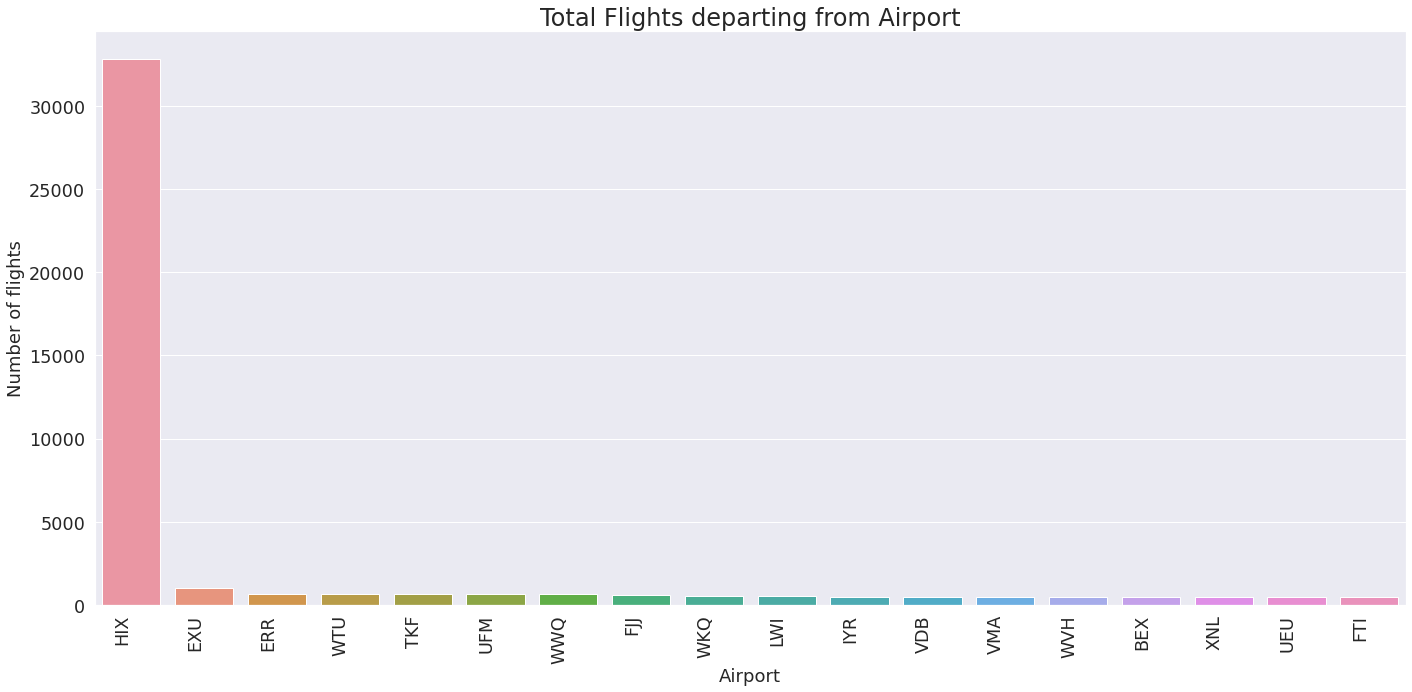

In [233]:
plt.figure(figsize=(20, 10))
sns.set(font_scale=1.6)
axis = sns.countplot(x=final_dataset['Origin_Airport'], data=final_dataset, order=final_dataset['Origin_Airport'].value_counts().iloc[0:18].index, orient="v")
axis.set_xticklabels(axis.get_xticklabels(), rotation=90, ha='right')
plt.title('Total Flights departing from Airport', fontsize=24)
plt.xlabel('Airport', fontsize=18)
plt.ylabel('Number of flights', fontsize=18)
plt.tight_layout()
plt.show()

<b>From the above chart we can see HIX is the Airport from where most of the flights are departing from in the month of December

## Top 20 Destinations where Flights are landing

In [102]:
final_dataset.Destination_Airport.value_counts().iloc[:20]

HIX    32806
EXU     1000
ERR      672
TKF      640
WTU      640
UFM      626
WWQ      615
FJJ      598
WKQ      537
LWI      533
IYR      478
VDB      475
WVH      474
VMA      474
BEX      468
FTI      449
XNL      448
UEU      446
BRB      437
LVU      429
Name: Destination_Airport, dtype: int64

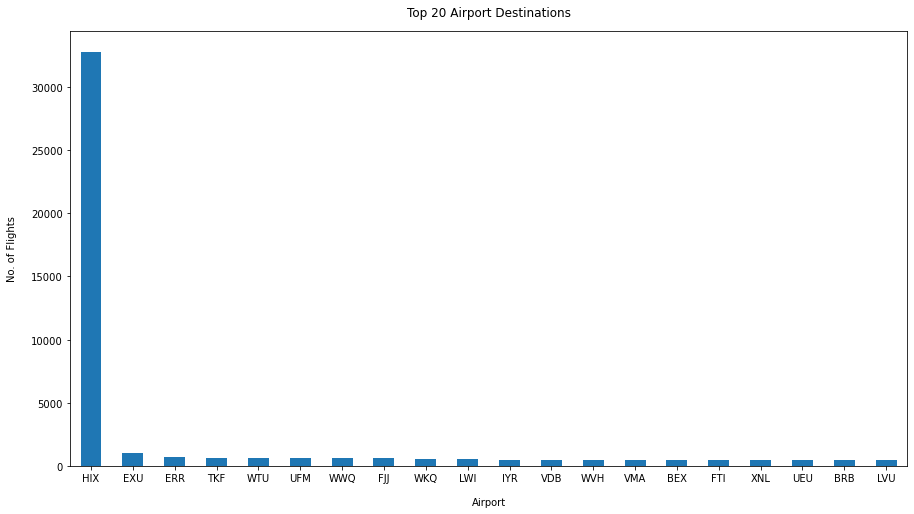

In [103]:
final_dataset.Destination_Airport.value_counts().iloc[:20].plot(kind='bar', figsize=(15,8), rot=0) 
plt.xlabel("Airport", labelpad=14)
plt.ylabel("No. of Flights", labelpad=14)
plt.title("Top 20 Airport Destinations", y=1.02);

<b>HIX is the top destination airport followed by EXU. This is the reason why most of the delays are happening in this particular airport, since it's the most busiest place.

## Analyzing airlines causing most delays

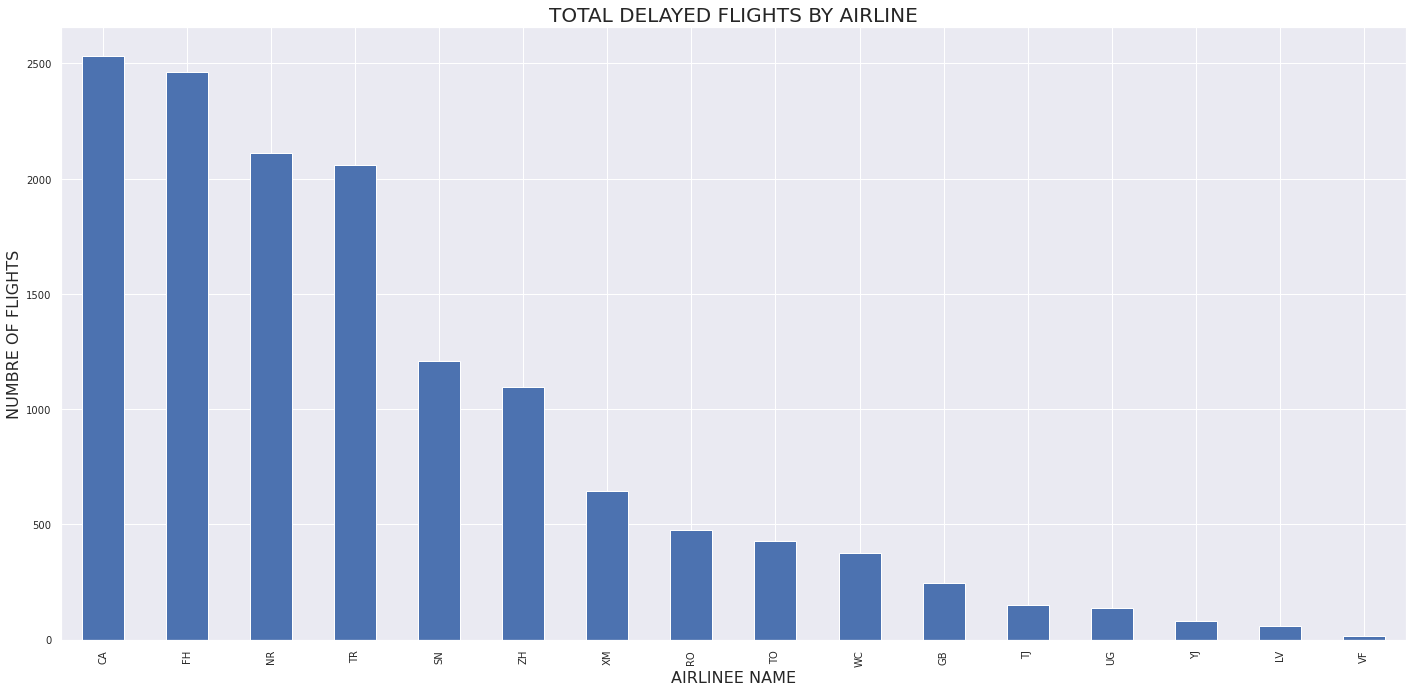

In [236]:
plt.figure(figsize=(20, 10))
final_dataset.groupby('Airline').IsDelay.sum().sort_values(ascending=False).plot.bar()
plt.title('TOTAL DELAYED FLIGHTS BY AIRLINE', fontsize=20)
plt.xlabel('AIRLINEE NAME', fontsize=16)
plt.ylabel('NUMBRE OF FLIGHTS', fontsize=16)
plt.rc('xtick',labelsize=10)
plt.rc('ytick',labelsize=10) 
plt.tight_layout()
plt.show()

<b> From the chart above it can be seen that the top 4 Airlines contributing to the delays being caused in CA, FH, NR and TR. The Company would need to check with these particular airlines why this is happening

## Analysing Departure delay VS Arrival Delay

This analysis will show us which of the two is the most contributing factor to the actual arrival delay happening for the Airlines.

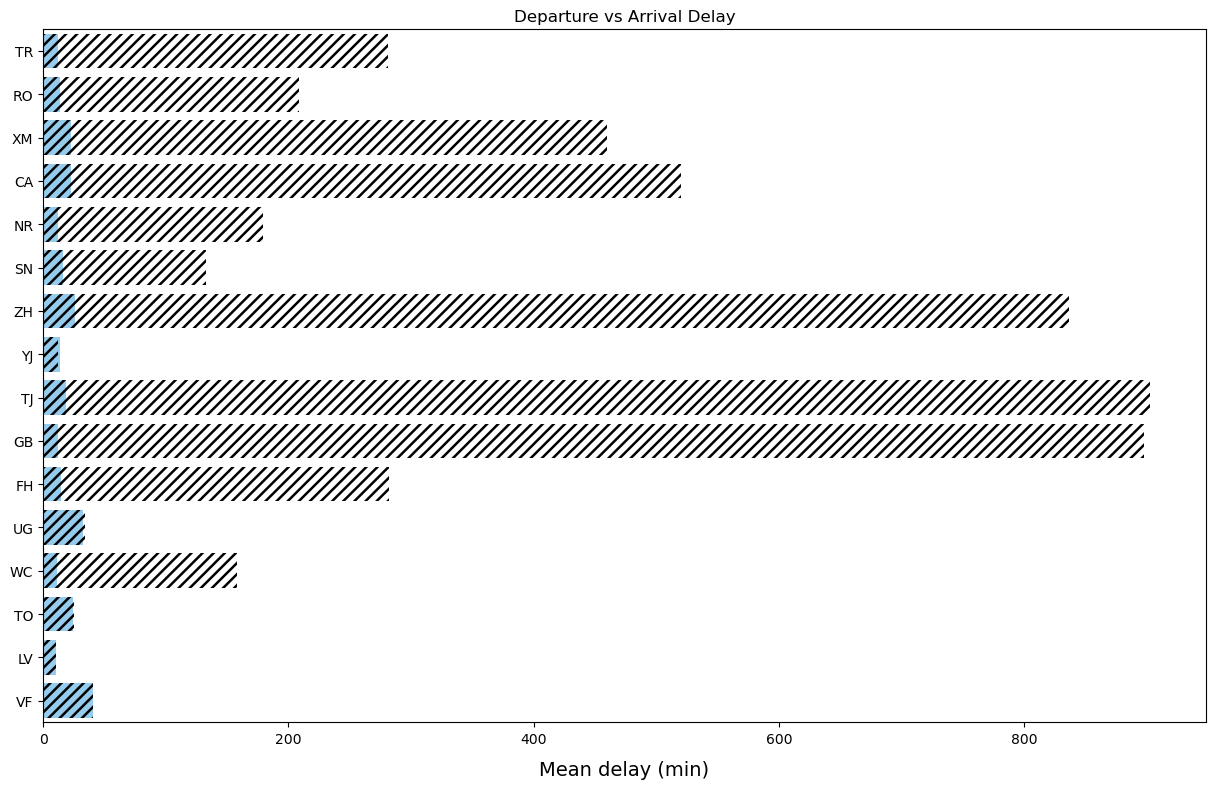

In [247]:
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams.update(mpl.rcParamsDefault)
mpl.rcParams['hatch.linewidth'] = 1.8  

fig = plt.figure(1, figsize=(15,9))
ax = sns.barplot(x="Departure_Delay_Minutes", y="Airline", data=final_dataset, color="lightskyblue", ci=None)
ax = sns.barplot(x="Arrival_Delay_Minutes", y="Airline", data=final_dataset, color="r", hatch = '///', alpha = 0.0, ci=None)
ax.yaxis.label.set_visible(False)
plt.title('Departure vs Arrival Delay')
plt.xlabel('Mean delay (min)', fontsize=14, labelpad=10);

<b>According to graph seen, for most of the airlines the departure delay is only minimal compared to the arrival delay. This could mean that either the airlines are not considering the extra time being elapsed and are not contributing to the customer satisfaction by hurrying up by adjusting flight speeds. It could also mean they have their time calculations all wrong. 

For some of the Airlines like VF, UG, TO, YJ even if there is a departure delay, they make sure to cover it up causing the minimal possible delay. These Airlines are very careful of the customer satisfaction they are delivering. LV seems to be the best Airline to be delivering that quality needed.

## Analyzing the correlations between the features

In [104]:
final_dataset.corr()

,Flight_Number,Flight_Distance,Scheduled_Departure_Time,Actual_Departure_Time,Departure_Delay_Minutes,Departure_Taxi,Departure_WheelsOff,Scheduled_Arrival_Time,Actual_Arrival_Time,Arrival_Delay_Minutes,Arrival_Taxi,Arrival_WheelsOn,Day,Month,IsDelay,WEEKDAY
Flight_Number,1.000000,-0.512545,0.000286,0.015596,0.055729,0.081297,0.030830,-0.017812,0.001246,0.005714,-0.016714,-0.003833,0.009137,NaN,0.056486,0.007751
Flight_Distance,-0.512545,1.000000,-0.015895,-0.028663,-0.021415,-0.041562,-0.048036,0.037238,0.018088,0.006020,0.012688,0.022817,0.051595,NaN,-0.022372,0.006063
Scheduled_Departure_Time,0.000286,-0.015895,1.000000,0.959753,0.036856,-0.009524,0.931480,0.723984,0.663731,0.001050,-0.036259,0.699490,-0.002883,NaN,0.060051,0.013826
Actual_Departure_Time,0.015596,-0.028663,0.959753,1.000000,0.074546,-0.001605,0.969686,0.723896,0.686122,0.007946,-0.031694,0.722680,0.003611,NaN,0.124682,-0.000276
Departure_Delay_Minutes,0.055729,-0.021415,0.036856,0.074546,1.000000,0.059158,0.069034,0.026681,0.007967,0.033673,0.005059,0.012293,0.031998,NaN,0.467583,-0.062337
Departure_Taxi,0.081297,-0.041562,-0.009524,-0.001605,0.059158,1.000000,0.028055,0.012408,0.004789,0.001582,-0.089872,0.010296,-0.003764,NaN,0.330395,-0.083749
Departure_WheelsOff,0.030830,-0.048036,0.931480,0.969686,0.069034,0.028055,1.000000,0.735600,0.707543,0.008095,-0.033220,0.744575,0.000406,NaN,0.130143,-0.002465
Scheduled_Arrival_Time,-0.017812,0.037238,0.723984,0.723896,0.026681,0.012408,0.735600,1.000000,0.855642,0.002524,-0.023712,0.850222,-0.000281,NaN,0.053338,0.004393
Actual_Arrival_Time,0.001246,0.018088,0.663731,0.686122,0.007967,0.004789,0.707543,0.855642,1.000000,0.008845,-0.001442,0.958663,0.004744,NaN,0.055971,-0.006027
Arrival_Delay_Minutes,0.005714,0.006020,0.001050,0.007946,0.033673,0.001582,0.008095,0.002524,0.008845,1.000000,0.010945,0.008534,0.007322,NaN,0.032212,-0.007922


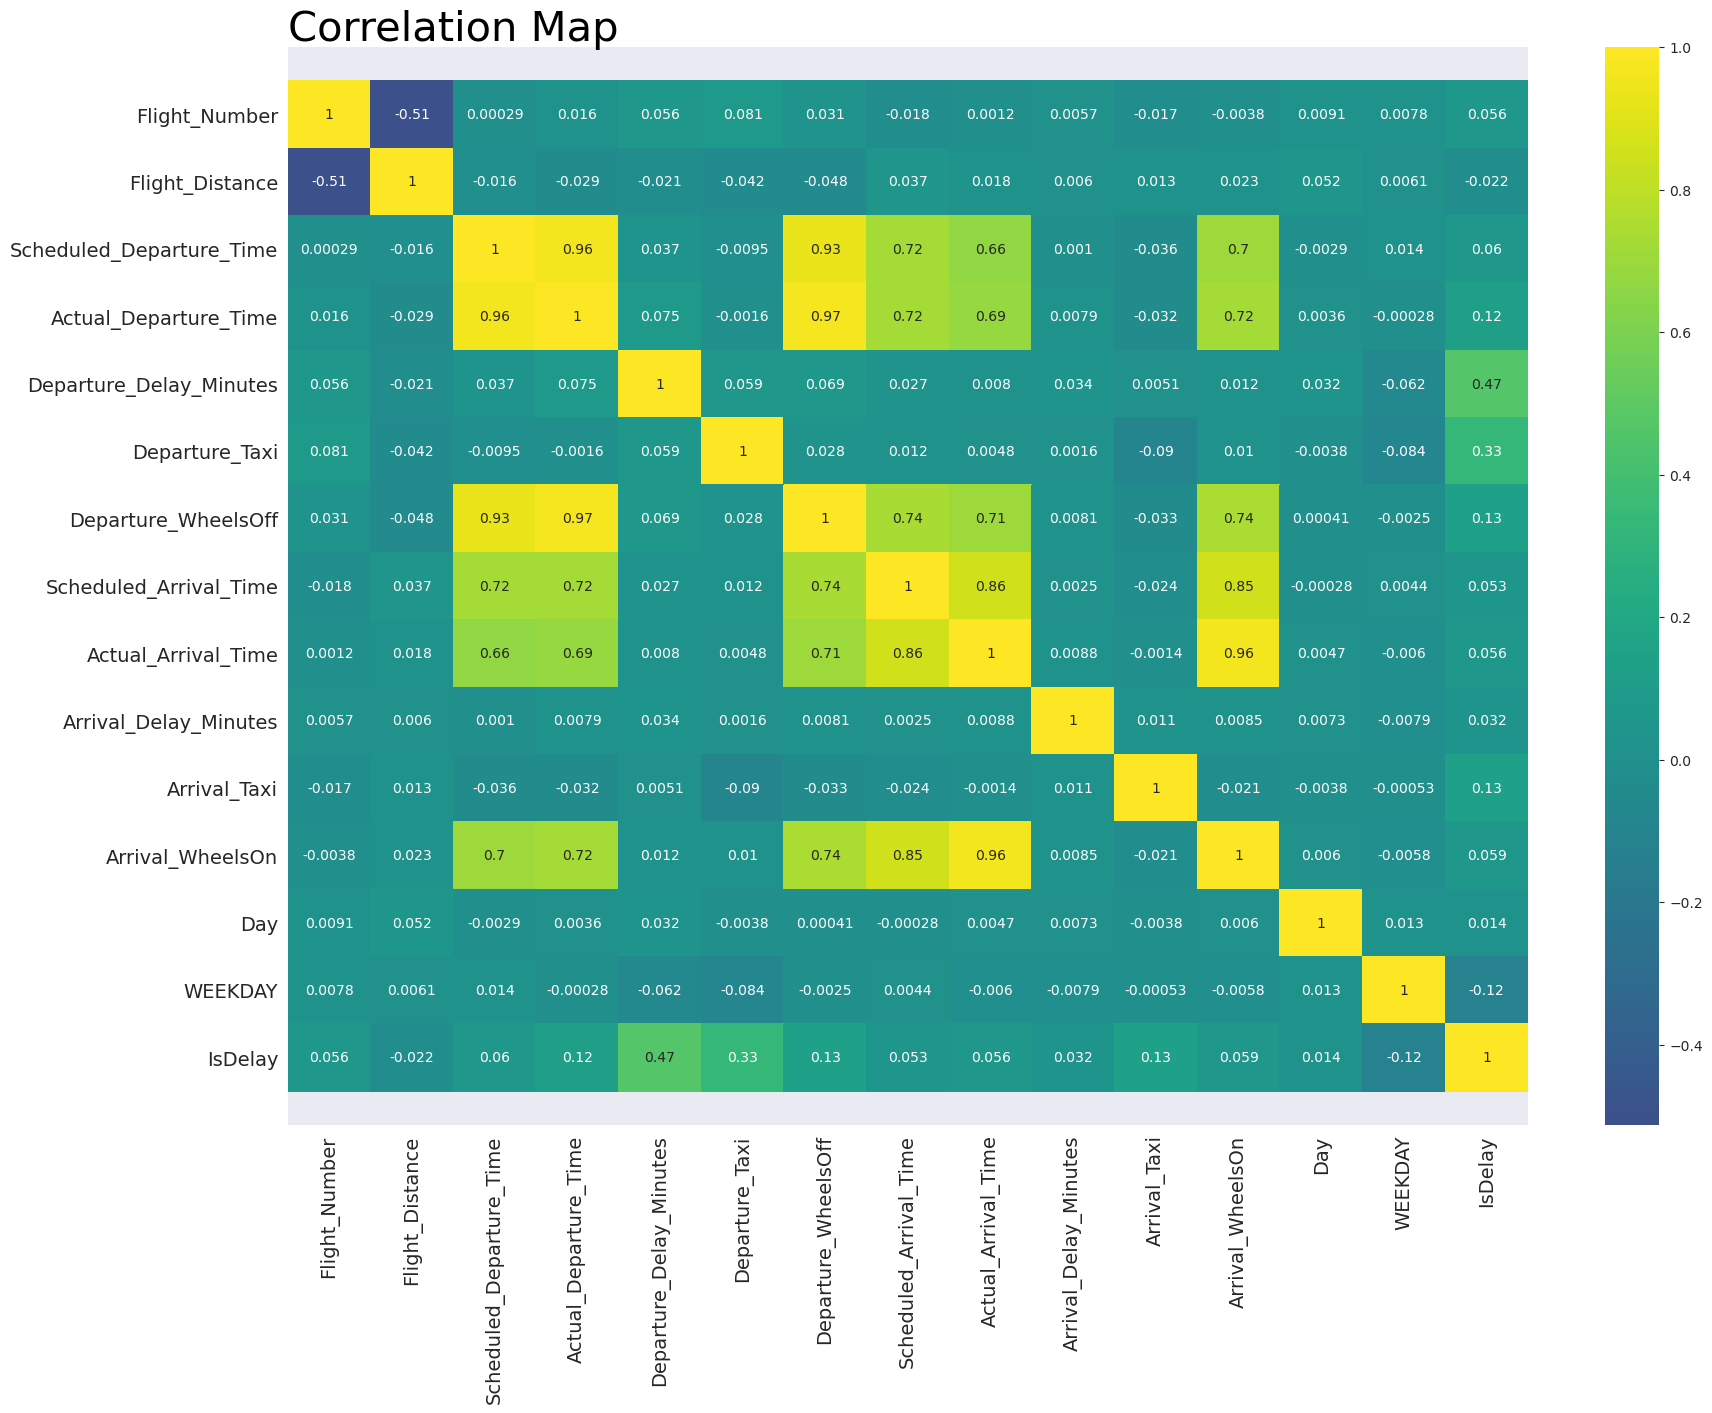

In [257]:
coor_data = final_dataset.drop(['Month'], axis = 1) 
plt.figure(figsize=(20,14))
ax = sns.heatmap(coor_data.corr(), cmap='viridis', center=0, annot=True)
bottom, top = ax.get_ylim()
plt.text(0,-0.6, "Correlation Map", fontsize = 30, color='Black', fontstyle='normal')
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.yticks(rotation=0, fontsize=14)
plt.xticks(rotation=90, fontsize=14)
plt.show()


<b>From the above chart it is observered that: 

There is a strong corelation between the Departure Taxi and the Arrival Taxi: meaning the times of departure wheels out and arrival wheels out are linked. Which is also trival considering the in-flight schedule being followed from time of taking off to landing.
<br>
The flight distance does not corelate strongly with the arrival delay: Means that the distance is not playing a major role in the flight being delayed. We can not say this though: Distance doesn't cause delay, because of the relationship and causation rule. 
<br>

Departure Taxi and IsDelay have a corelation as well: There is some corelation here as well, which means that the company has to assess when the departure wheels are coming out because it seems to be causing some delay in this case. 
<br>

IsDelay and Departure Delay Minutes have a corelationship: This means that a delay in the departure is contributing to the flight delay issue here. 
<br>

Arrival Taxi and Departure Delay Minutes: This is trival since these 2 events are very different from each. 
<br>

Also a strong correlation between isDelay and Departure delay than isDelay and Arrival Delay: meaning a late departure is a major contributing factor in flights being delayed than late arrivals (time spent in between the flights).
<br>

Other aspects are very trival like: strong relationship between arrival wheels on and departure time, departure wheels off and scheduled arrival time, etc.

## The Spread out of data - Histogram

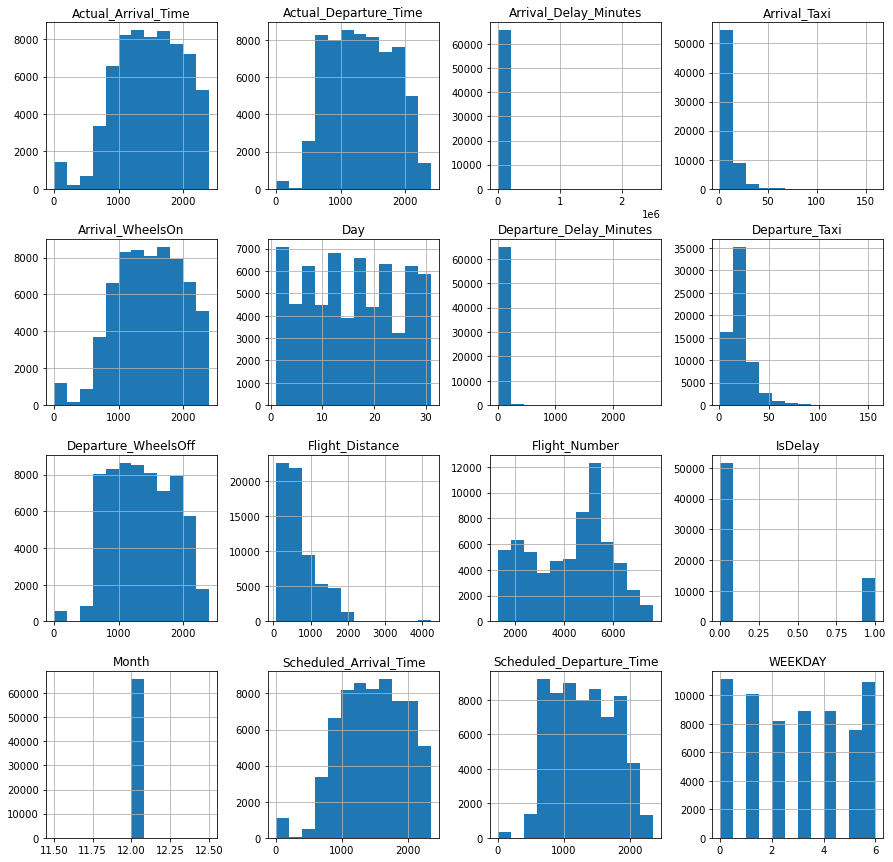

In [106]:
final_dataset.hist(figsize  = [15, 15],bins=12) 
plt.show()

Some observations: 

Fewer flights on the 25th December
<br>
Most flights on weekdays -Sunday and Monday
<br>
Most data for on time flights than delays
<br>



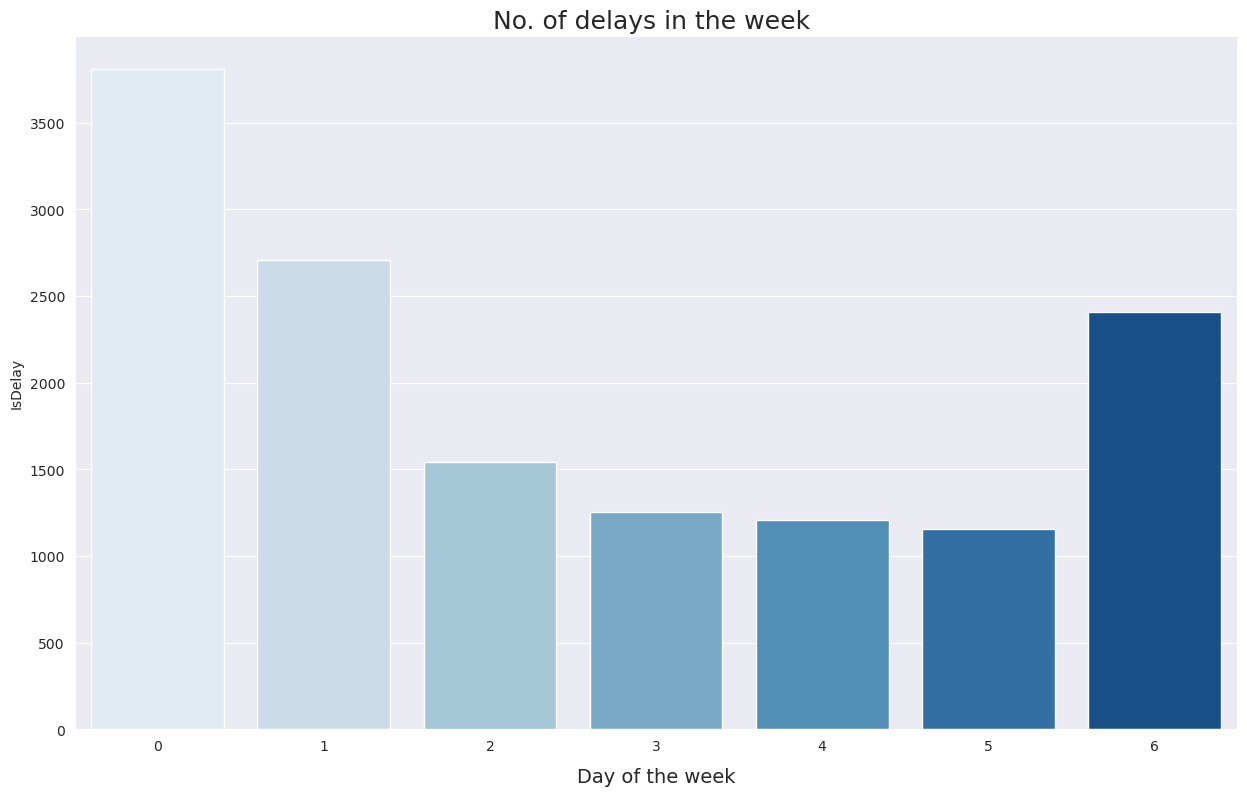

In [248]:
### Checking out when most of the flights are delayed in the week
sns.set_style('darkgrid')

fig = plt.figure(1, figsize=(15,9))
ax = sns.barplot(x="WEEKDAY", y="IsDelay", data=final_dataset, palette="Blues", ci=None, estimator=sum)
plt.title('No. of delays in the week ', fontsize=18)
plt.xlabel('Day of the week', fontsize=14, labelpad=10);
plt.show()

<b>Most of the delays as seen in the chart above are occuring on Monday followed by Tuesday. The least delays occur on Friday & Saturday which is actually the weekend. This can be analysed further if customer and country behaviour is present in the dataset. But a recommendation here to Compass Airlines would be to be strict on these days and find more by looking at customer, location and airplane schedule history.

### Analysing what reason causing the most delay

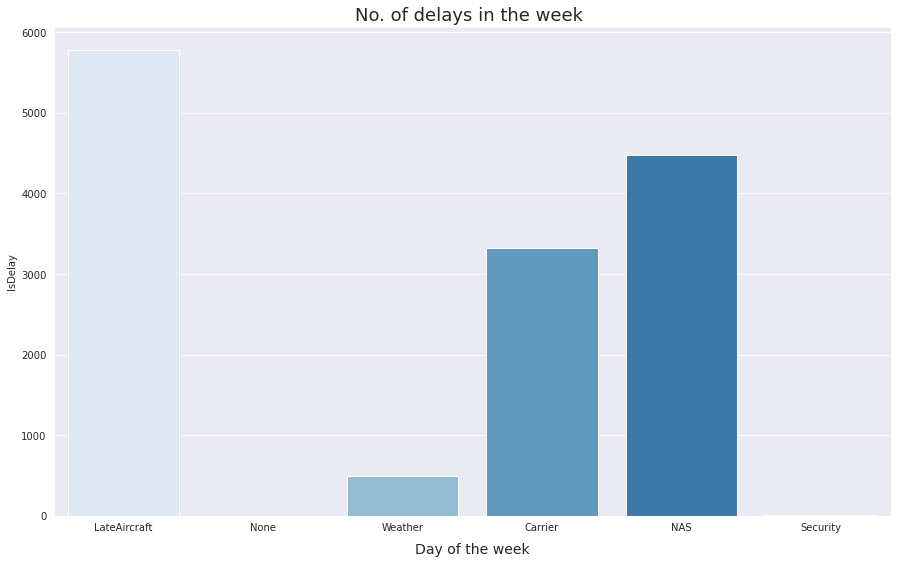

In [112]:

sns.set_style('darkgrid')

fig = plt.figure(1, figsize=(15,9))
ax = sns.barplot(x="Delay_Reason", y="IsDelay", data=final_dataset, palette="Blues", ci=None, estimator=sum)
plt.title('No. of delays in the week ', fontsize=18)
plt.xlabel('Day of the week', fontsize=14, labelpad=10);
plt.show()

<b>From the above chart it is clear that because the Aircraft is late from it's previous flight or other factors involved, that is the main reason why the entire flight ends up being delayed. Weather is barely playing a role in the flight being late in this month (December) of flights. This is also one of the reasons why I did not choose to include the weather data at this point. But I would want to use the weather data later, and if I would have had more time.

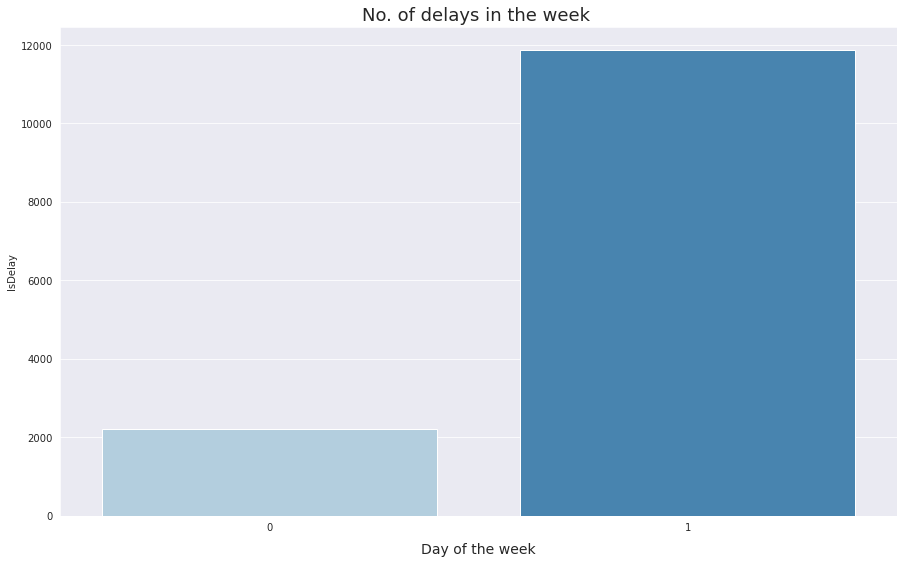

In [210]:
filtered_data = final_dataset
status = []

for value in filtered_data['Departure_Delay_Minutes']:
    if int(value) >= 0.5:
        status.append(1) #yes there is a delay
    else:
        status.append(0) #there is no delay
filtered_data['Dep_Delay'] = status
filtered_data.head() 



sns.set_style('darkgrid')

fig = plt.figure(1, figsize=(15,9))
ax = sns.barplot(x="Dep_Delay", y="IsDelay", data=filtered_data, palette="Blues", ci=None, estimator=sum)
plt.title('No. of delays in the week ', fontsize=18)
plt.xlabel('Day of the week', fontsize=14, labelpad=10);
plt.show()


<b> From the above chart it can be seen that departure delay along with the aircraft being late is causing the most delay to the flights. These are the key points that Compass Airlines needs to start working on immediately.

# Model Building

For this part, I would like to go with Random Forests becasue the approach is simple, efficient and will give the highest accuracy, especially considering  the amount of data and the kind of data I have

### Encoding Delay_Reason for model building

In [162]:
model_dataset = final_dataset 
from sklearn.preprocessing import LabelEncoder

# Performing label encoding on the delay_reason column to convert it into numerical form for building the model
le = LabelEncoder()
model_dataset['Delay_Reason'] = le.fit_transform(model_dataset['Delay_Reason'])
model_dataset['Airline'] = le.fit_transform(model_dataset['Airline']) 
model_dataset['Origin_Airport'] = le.fit_transform(model_dataset['Origin_Airport']) 
model_dataset['Destination_Airport'] = le.fit_transform(model_dataset['Destination_Airport']) 
model_dataset.head()

,Airline,Flight_Number,Plane_ID,FlightDate,Origin_Airport,Destination_Airport,Flight_Distance,Scheduled_Departure_Time,Actual_Departure_Time,Departure_Delay_Minutes,Departure_Taxi,Departure_WheelsOff,Scheduled_Arrival_Time,Actual_Arrival_Time,Arrival_Delay_Minutes,Arrival_Taxi,Arrival_WheelsOn,Delay_Reason,Day,Month,MONTH_AB,IsDelay,WEEKDAY
0,9,4135,GJLOAB,2019-12-01,54,43,678,1,103,62,15,118,127,219,52,7,212,1,1,12,Dec,1,6
1,9,3776,GDISCI,2019-12-01,42,43,1700,10,25,15,21,46,616,624,8,27,557,3,1,12,Dec,0,6
2,5,4754,GHHWLL,2019-12-01,43,56,413,10,10,0,15,25,242,227,0,5,222,3,1,12,Dec,0,6
3,13,5604,GBGWFC,2019-12-01,43,57,130,10,44,34,34,118,111,155,44,4,151,5,1,12,Dec,1,6
4,13,5612,GBISBC,2019-12-01,43,74,258,10,234,144,26,300,132,358,146,6,352,0,1,12,Dec,1,6



### Dropping unnecessary columns

The first 4 columns mentioned below are dropped because they will not contribute anything to the model, the next features are deleted because these values are occuring in the future once the delay/no delay has already occured, so it won't be needed as well

In [163]:
model_dataset = model_dataset.drop(['Flight_Number'], axis = 1) 
model_dataset = model_dataset.drop(['Plane_ID'], axis = 1) 
model_dataset = model_dataset.drop(['FlightDate'], axis = 1)
model_dataset = model_dataset.drop(['MONTH_AB'], axis = 1) 
model_dataset = model_dataset.drop(['Month'], axis = 1)
model_dataset = model_dataset.drop(['Actual_Arrival_Time'], axis = 1) 
model_dataset = model_dataset.drop(['Arrival_Delay_Minutes'], axis = 1) 
model_dataset = model_dataset.drop(['Arrival_Taxi'], axis = 1) 
model_dataset = model_dataset.drop(['Arrival_WheelsOn'], axis = 1) 
model_dataset = model_dataset.drop(['Delay_Reason'], axis = 1)
model_dataset.head()

,Airline,Origin_Airport,Destination_Airport,Flight_Distance,Scheduled_Departure_Time,Actual_Departure_Time,Departure_Delay_Minutes,Departure_Taxi,Departure_WheelsOff,Scheduled_Arrival_Time,Day,IsDelay,WEEKDAY
0,9,54,43,678,1,103,62,15,118,127,1,1,6
1,9,42,43,1700,10,25,15,21,46,616,1,0,6
2,5,43,56,413,10,10,0,15,25,242,1,0,6
3,13,43,57,130,10,44,34,34,118,111,1,1,6
4,13,43,74,258,10,234,144,26,300,132,1,1,6


## Data Distribution

So this data is obviously not balanced, but this code is just for workflow purposes

Legend:
0    51588
1    14081
Name: IsDelay, dtype: int64


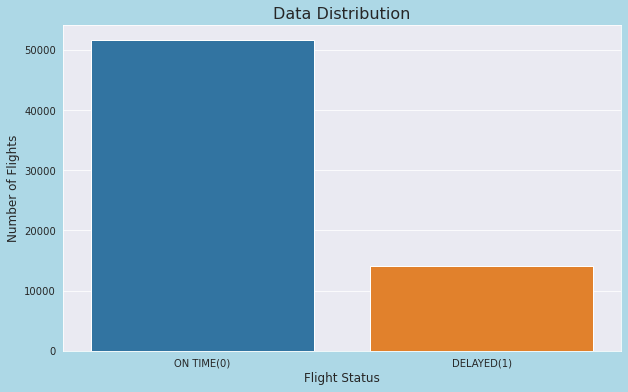

In [164]:
case_count = model_dataset['IsDelay'].value_counts() # 'data' is our input which will be any of the 3 dataframes created
print('Legend:')
print(case_count)

plt.figure(figsize=(10,6))
sns.barplot(x=case_count.index, y=case_count.values)
plt.rcParams["figure.facecolor"] = "lightblue"
plt.title('Data Distribution', fontsize=16)
plt.xlabel('Flight Status', fontsize=12)
plt.ylabel('Number of Flights', fontsize=12)
plt.xticks(range(len(case_count.index)), ['ON TIME(0)', 'DELAYED(1)'])
plt.show()


In [165]:
model_dataset.IsDelay.value_counts(normalize=True)

0    0.785576
1    0.214424
Name: IsDelay, dtype: float64

So I will keep the the dataset in the same balance and use Bootstrat Class Weighting while creating a random forest to avoid the imbalanced class problem for this problem set 

## Labeling & Spliting data

In [166]:

# Create features (X) and labels (y)
y = model_dataset['IsDelay']
X = model_dataset.drop(['IsDelay'], axis=1)

# Perform the split
X_test, X_train, y_test, y_train = train_test_split(X, y, test_size=0.25, random_state=42)

## Creating Random Forest Model - Bootstrat Class Weighting

The below code will take into account that the data is imbalanced. Read below description of class weighting in random forest: 

Given that each decision tree is constructed from a bootstrap sample (e.g. random selection with replacement), the class distribution in the data sample will be different for each tree.

As such, it might be interesting to change the class weighting based on the class distribution in each bootstrap sample, instead of the entire training dataset.

This can be achieved by setting the class_weight argument to the value ‘balanced_subsample‘.

In [167]:
forest_bcw = RandomForestClassifier(n_estimators=100, max_depth=5, class_weight='balanced_subsample')
forest_bcw.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced_subsample', max_depth=5)

### Training Accuracy

In [168]:
# Now to check the accuracy score
forest_bcw.score(X_train, y_train)

0.9184431721281521

### Testing Accuracy

In [169]:
# And for the test set:
forest_bcw.score(X_test, y_test)

0.9141134190168727

In [170]:
# Test set predictions
pred_rfbcw = forest_bcw.predict(X_test)

### Confusion Matrix

In [171]:
# confusion matrix and classfication report
print('\nConfusion Matrix')
print('----------------')
pd.crosstab(y_test, pred_rfbcw, rownames=['True'], colnames=['Predicted'], margins=True)


Confusion Matrix
----------------


Predicted,0,1,All
True,,,
0,35599,3000,38599
1,1230,9422,10652
All,36829,12422,49251


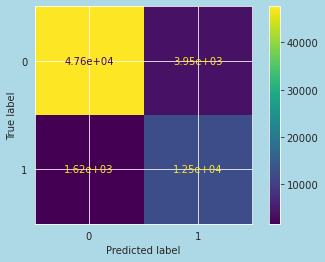

In [177]:
# Alternative confusion matrix
plot_confusion_matrix(forest_bcw, X, y, values_format='.3g')
plt.show()

<b>From the above confusion matrix it can be seen that model built has a higher false negative rate than false positive this means that if an error happens then customers will be informed more about "yes, a delay will occur" when it won't happen than "no, a delay will happen" when it will happen. This is a actually a better case scenario for this problem since we need increase the NPS along with the trust of the customers. If in case an error happens and we tell customers a delay won't happen when it will, this will set a negative image for Compass Airlines. But if we say a delay will happen when in reality it doesn't, this will increase the satisfaction and the trust of the customer, increasing the airline's quality.

### Feature Importance

In [172]:
forest_bcw.feature_importances_

array([0.00201514, 0.0014634 , 0.00131225, 0.00378302, 0.024807  ,
       0.01975702, 0.68595586, 0.1663709 , 0.02638929, 0.00983334,
       0.0319497 , 0.02636307])

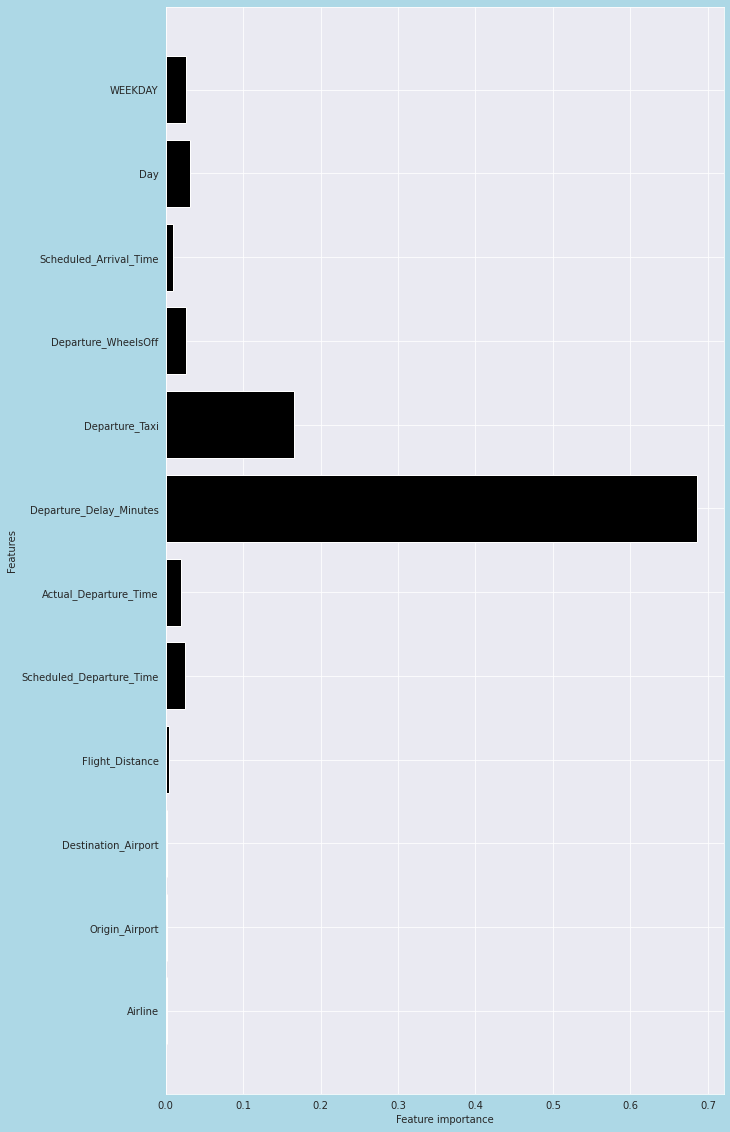

In [173]:
def plot_feature_importances(model):
    n_features = X_train.shape[1]
    plt.figure(figsize=(10, 20))
    plt.barh(range(n_features), model.feature_importances_, color='k', align='center')
    plt.yticks(np.arange(n_features), X_train.columns.values)
    plt.xlabel('Feature importance')
    plt.ylabel('Features')
    plt.rcParams["figure.facecolor"] = "lightblue"
    plt.grid(True)
plot_feature_importances(forest_bcw)
plt.rcParams["figure.facecolor"] = "lightblue"

<b>From the above chart we can see which features are contributing the most to the decision - Delay or No Delay. We can see here that delay in the departure is a main feature contributing to it and we also saw in before in one of that analysis that a 'late aircraft' is the one causing the most delay. My first recommendation to Compass airline would be is to ensure their aircrafts are arriving on time, their scheduled is fixed so that the flight delays don't keep occuring.

Another reason we can see apart of the departure and the departure taxi is the day of the week, you can see that it is also causing an effect on the flight being delayed.

In [175]:
print('Classificiation Report')
print('---------------------')
print(classification_report(y_test, pred_rfbcw))


Classificiation Report
---------------------
              precision    recall  f1-score   support

           0       0.97      0.92      0.94     38599
           1       0.76      0.88      0.82     10652

    accuracy                           0.91     49251
   macro avg       0.86      0.90      0.88     49251
weighted avg       0.92      0.91      0.92     49251



<b>I have already explained my views on the model in regards to the confusion matrix above which applies here as well. From this report we can see that the model provides a very high precision and recall which in return makes the f1-score very high too. With this being said the model is extremely accurate and can also classify cases that are difficult to assess as well. (please refer to my explaination for the confusion matrix part as well).

In [178]:
print("Testing Accuracy for RandomForest Classifier for the predicting flight delay is: {:.4}%".format(accuracy_score(y_test, pred_rfbcw) * 100))

Testing Accuracy for RandomForest Classifier for the predicting flight delay is: 91.41%


roc_auc_score:  0.9034032531083513


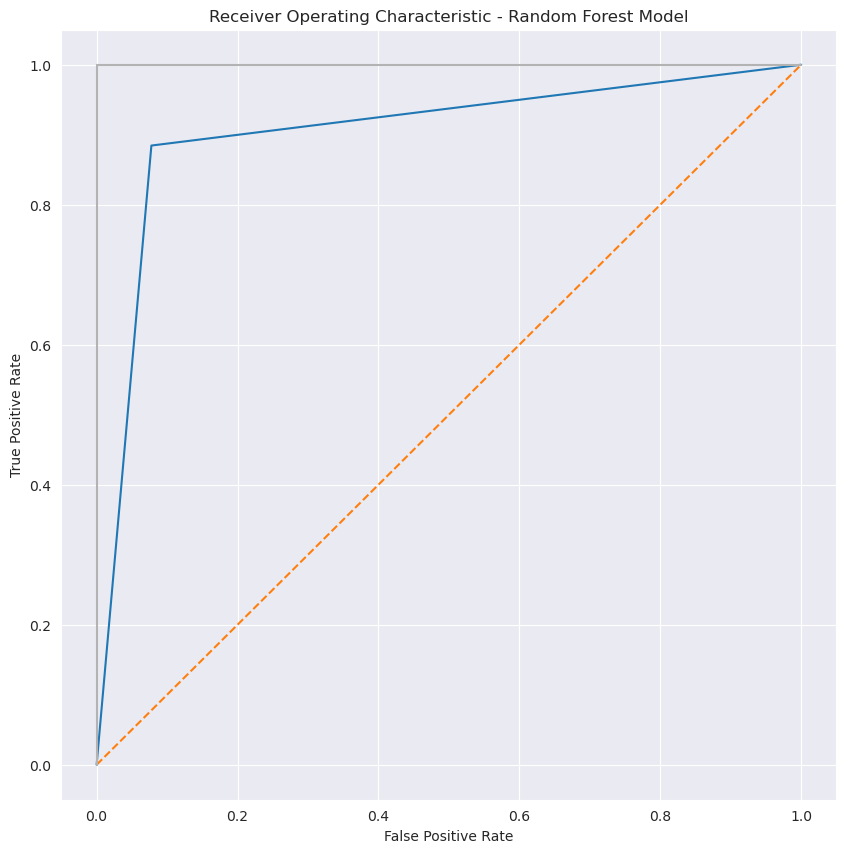

In [266]:
from sklearn.metrics import roc_curve, roc_auc_score
false_positive_rate1, true_positive_rate1, threshold1 = roc_curve(y_test, pred_rfbcw)
print('roc_auc_score: ', roc_auc_score(y_test, pred_rfbcw)) 

plt.subplots(1, figsize=(10,10))
plt.title('Receiver Operating Characteristic - Random Forest Model')
plt.plot(false_positive_rate1, true_positive_rate1)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

<b><h3>With more time in hand: </h3>  
   I want to more detailed analysis of the data and find more insights more this. I would want to use Tableau to do more deeper analysis on the reasons and connect with some geographical or other information to do more analysis. <br>
   I would want to analyse the same data in regards to the weather as well, because that plays a part here too. Because of lack of time, I skipped that analysis for now.
    <br>
    I also wanted to perform hyperparameter optimization as well on the model to achieve a better result. But I have have skipped on that because even without it, my model is performing really well. The real assesment of the data would be when other month's data would be presented to it. <br> 
    I also wanted to showcase fairness and explainability of the model using Lime to showcase for each particular decision made by the model, which features are playing a major role here.